# Multilayer Perceptron (MLP)

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/logo.png" width=150>

In this lesson, we will explore multilayer perceptrons which are a basic type of neural network. We will implement them using PyTorch.

**Note**: This notebook is an introduction to MLPs in PyTorch so we won't follow proper machine learning techniques to keep things short and simple (class balance in train/test splits, validation sets, early stopping, etc.).  We will implement best practices in the next notebook.



# Overview

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/mlp.png" width=450>

$z_2 = XW_1$

$a_2 = f(z_2)$

$z_3 = a_2W_2$

$\hat{y} = softmax(z_3)$ # classification

*where*:
* $X$ = inputs | $\in \mathbb{R}^{NXD}$ ($D$ is the number of features)
* $W_1$ = 1st layer weights | $\in \mathbb{R}^{DXH}$ ($H$ is the number of hidden units in layer 1)
* $z_2$ = outputs from first layer's weights  $\in \mathbb{R}^{NXH}$
* $f$ = non-linear activation function
* $a_2$ = activation applied first layer's outputs | $\in \mathbb{R}^{NXH}$
* $W_2$ = 2nd layer weights | $\in \mathbb{R}^{HXC}$ ($C$ is the number of classes)
* $\hat{y}$ = prediction | $\in \mathbb{R}^{NXC}$ ($N$ is the number of samples)

This is a simple two-layer MLP. 

* **Objective:**  Predict the probability of class $y$ given the inputs $X$. Non-linearity is introduced to model the complex, non-linear data.
* **Advantages:**
  * Can model non-linear patterns in the data really well.
* **Disadvantages:**
  * Overfits easily.
  * Computationally intensive as network increases in size.
  * Not easily interpretable.
* **Miscellaneous:** Future neural network architectures that we'll see use the MLP as a modular unit for feed forward operations (affine transformation (XW) followed by a non-linear operation).

# Training

*Steps*:

1. Randomly initialize the model's weights $W$ (we'll cover more effective initalization strategies in future lessons).
2. Feed inputs $X$ into the model to do the forward pass and receive the probabilities.
3. Compare the predictions $\hat{y}$ (ex.  [0.3, 0.3, 0.4]]) with the actual target values $y$ (ex. class 2 would look like [0, 0, 1]) with the objective (cost) function to determine loss $J$. A common objective function for classification tasks is cross-entropy loss. 
  * $z_2 = XW_1$
  * $a_2 = max(0, z_2)$ # ReLU activation
  * $z_3 = a_2W_2$
  * $\hat{y} = softmax(z_3)$
  * $J(\theta) = - \sum_i y_i ln (\hat{y_i}) $
4. Calculate the gradient of loss $J(\theta)$ w.r.t to the model weights. 
   * $ \frac{\partial{J}}{\partial{W_{2j}}} = a_2\hat{y}, \frac{\partial{J}}{\partial{W_{2y}}} = a_2(\hat{y}-1) $
   * $ \frac{\partial{J}}{\partial{W_1}} = \frac{\partial{J}}{\partial{\hat{y}}} \frac{\partial{\hat{y}}}{\partial{a_2}}  \frac{\partial{a_2}}{\partial{z_2}}  \frac{\partial{z_2}}{\partial{W_1}}  = W_2(\partial{scores})(\partial{ReLU})X $
   
5. Apply backpropagation to update the weights $W$ using gradient descent. The updates will penalize the probabiltiy for the incorrect classes (j) and encourage a higher probability for the correct class (y).
  * $W_i = W_i - \alpha\frac{\partial{J}}{\partial{W_i}}$
6. Repeat steps 2 - 4 until model performs well.

# Data

We're going to first generate some non-linear data for a classification task.

In [0]:
# Load PyTorch library
!pip3 install torch torchvision

In [0]:
from argparse import Namespace
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

In [0]:
# Arguments
args = Namespace(
    seed=1234,
    num_samples_per_class=500,
    dimensions=2,
    num_classes=3,
    train_size=0.75,
    test_size=0.25,
    num_hidden_units=100,
    learning_rate=1e-0,
    regularization=1e-3,
    num_epochs=200,
)

# Set seed for reproducability
np.random.seed(args.seed)

In [0]:
# Generate non-linear data
def generate_data(num_samples_per_class, dimensions, num_classes):
    # Make synthetic spiral data
    X_original = np.zeros((num_samples_per_class*num_classes, dimensions))
    y = np.zeros(num_samples_per_class*num_classes, dtype='uint8')
    for j in range(num_classes):
        ix = range(num_samples_per_class*j,num_samples_per_class*(j+1))
        r = np.linspace(0.0,1,num_samples_per_class) # radius
        t = np.linspace(j*4,(j+1)*4,num_samples_per_class) + \
        np.random.randn(num_samples_per_class)*0.2 # theta
        X_original[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j

    # Stack
    X = np.hstack([X_original])

    return X, y

In [0]:
# Generate X & y
X, y = generate_data(num_samples_per_class=args.num_samples_per_class, 
                     dimensions=args.dimensions, num_classes=args.num_classes)
print ("X: {0}".format(np.shape(X)))
print ("y: {0}".format(np.shape(y)))

X: (1500, 2)
y: (1500,)


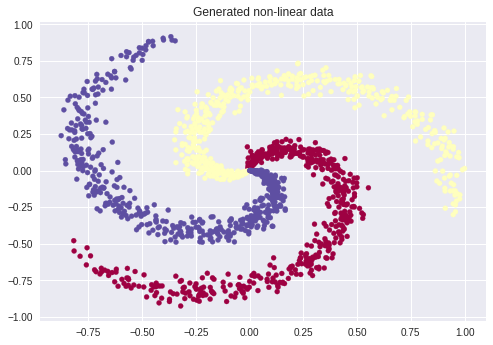

In [0]:
# Visualize data
plt.title("Generated non-linear data")
plt.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap=plt.cm.Spectral)
plt.show()

In [0]:
# Convert to PyTorch tensors
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

In [0]:
# Shuffle data
shuffle_indicies = torch.LongTensor(random.sample(range(0, len(X)), len(X)))
X = X[shuffle_indicies]
y = y[shuffle_indicies]

# Split datasets
test_start_idx = int(len(X) * args.train_size)
X_train = X[:test_start_idx] 
y_train = y[:test_start_idx] 
X_test = X[test_start_idx:] 
y_test = y[test_start_idx:]
print("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))

We have 1125 train samples and 375 test samples.


# Linear model

Before we get to our neural network, we're going to implement a linear model (logistic regression) in PyTorch first. We want to see why linear models won't suffice for our dataset.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

In [0]:
# Linear model
class LogisticClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LogisticClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        a_1 = self.fc1(x_in)
        y_pred = self.fc2(a_1)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred

In [0]:
# Initialize model
model = LogisticClassifier(input_dim=args.dimensions, 
                           hidden_dim=args.num_hidden_units, 
                           output_dim=args.num_classes)
print (model.named_modules)

<bound method Module.named_modules of LogisticClassifier(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


In [0]:
# Optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate) # Adam optimizer (usually better than SGD)

In [0]:
# Accuracy
def get_accuracy(y_pred, y_target):
    n_correct = torch.eq(y_pred, y_target).sum().item()
    accuracy = n_correct / len(y_pred) * 100
    return accuracy

In [0]:
# Training
for t in range(args.num_epochs):
    # Forward pass
    y_pred = model(X_train)
    
    # Accuracy
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)

    # Loss
    loss = loss_fn(y_pred, y_train)
    
    # Verbose
    if t%20==0: 
        print ("epoch: {0:02d} | loss: {1:.4f} | acc: {2:.1f}%".format(
            t, loss, accuracy))

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

epoch: 00 | loss: 1.1694 | acc: 32.6%
epoch: 20 | loss: 14.5043 | acc: 55.1%
epoch: 40 | loss: 3.9626 | acc: 54.1%
epoch: 60 | loss: 1.3633 | acc: 54.0%
epoch: 80 | loss: 0.7533 | acc: 54.5%
epoch: 100 | loss: 0.7478 | acc: 55.6%
epoch: 120 | loss: 0.7330 | acc: 54.2%
epoch: 140 | loss: 0.7329 | acc: 54.0%
epoch: 160 | loss: 0.7327 | acc: 53.8%
epoch: 180 | loss: 0.7327 | acc: 53.8%


In [0]:
# Predictions
_, pred_train = model(X_train, apply_softmax=True).max(dim=1)
_, pred_test = model(X_test, apply_softmax=True).max(dim=1)

In [0]:
# Train and test accuracies
train_acc = get_accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 53.8%, test acc: 53.1%


In [0]:
# Visualization
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    
    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = model(X_test, apply_softmax=True)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

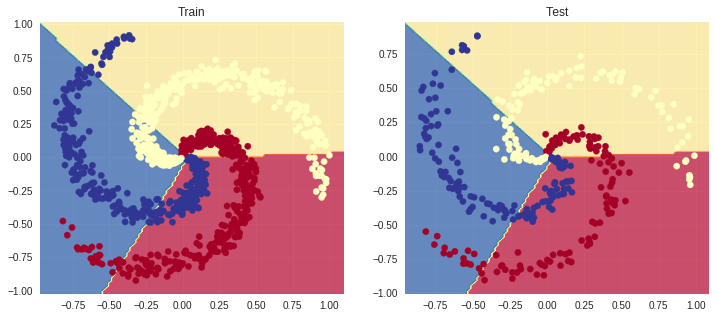

In [0]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

In [0]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

             precision    recall  f1-score   support

          0       0.50      0.50      0.50       125
          1       0.55      0.55      0.55       117
          2       0.54      0.55      0.54       133

avg / total       0.53      0.53      0.53       375



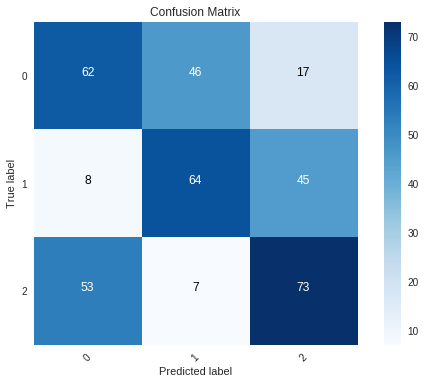

In [0]:
# Confusion matrix
cm = confusion_matrix(y_test, pred_test)
plot_confusion_matrix(cm=cm, classes=[0, 1, 2])
print (classification_report(y_test, pred_test))

# Non-linear model

Now let's see how the MLP performs on the data. Note that the only difference is the addition of the non-linear activation function (we use ReLU which is just $max(0, z))$. 

In [0]:
# Multilayer Perceptron 
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        a_1 = F.relu(self.fc1(x_in)) # activaton function added!
        y_pred = self.fc2(a_1)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred

In [0]:
# Initialize model
model = MLP(input_dim=args.dimensions, 
            hidden_dim=args.num_hidden_units, 
            output_dim=args.num_classes)
print (model.named_modules)

<bound method Module.named_modules of MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


In [0]:
# Optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

In [0]:
# Training
for t in range(args.num_epochs):
    # Forward pass
    y_pred = model(X_train)
    
    # Accuracy
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)

    # Loss
    loss = loss_fn(y_pred, y_train)
    
    # Verbose
    if t%20==0: 
        print ("epoch: {0:02d} | loss: {1:.4f} | acc: {2:.1f}%".format(
            t, loss, accuracy))

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

epoch: 00 | loss: 1.1470 | acc: 23.7%
epoch: 20 | loss: 0.5179 | acc: 71.6%
epoch: 40 | loss: 0.2400 | acc: 87.8%
epoch: 60 | loss: 0.1402 | acc: 93.3%
epoch: 80 | loss: 0.0560 | acc: 98.9%
epoch: 100 | loss: 0.0344 | acc: 99.2%
epoch: 120 | loss: 0.0283 | acc: 99.6%
epoch: 140 | loss: 0.0241 | acc: 99.7%
epoch: 160 | loss: 0.0215 | acc: 99.8%
epoch: 180 | loss: 0.0197 | acc: 99.8%


In [0]:
# Predictions
_, pred_train = model(X_train, apply_softmax=True).max(dim=1)
_, pred_test = model(X_test, apply_softmax=True).max(dim=1)

In [0]:
# Train and test accuracies
train_acc = get_accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 99.8%, test acc: 99.7%


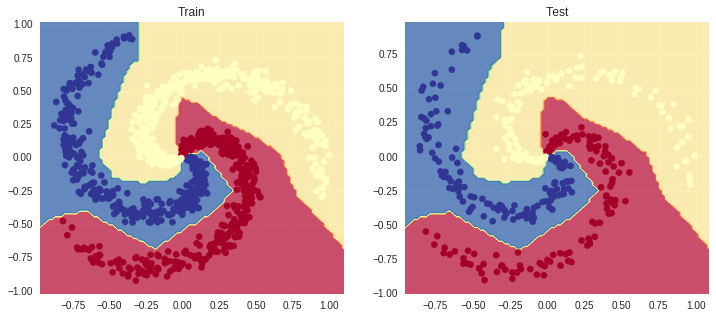

In [0]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

             precision    recall  f1-score   support

          0       0.99      1.00      1.00       125
          1       1.00      0.99      1.00       117
          2       1.00      1.00      1.00       133

avg / total       1.00      1.00      1.00       375



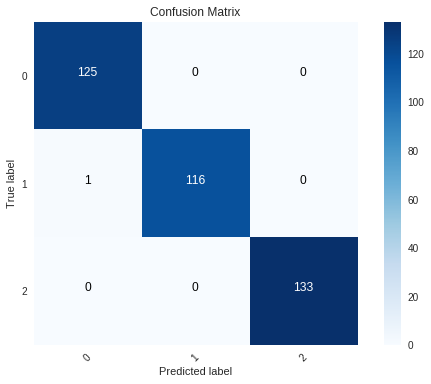

In [0]:
# Confusion matrix
cm = confusion_matrix(y_test, pred_test)
plot_confusion_matrix(cm=cm, classes=[0, 1, 2])
print (classification_report(y_test, pred_test))

# Visualizing weights

So far, we've seen metrics like loss and accuracy and even visualized decision boundaries. But what about our weights? It's a little tricky to visualize them because there are so many and they are constantly all updated. But this is crucial because our weights can casue many downstream issues such as all the weights being nearly zero or weights quickly growing in magnitude. Both of these issues indicate that our model needs some finetuning/normalization but we need to be able to see our weights to discern this. Since the weights can have large dimensions, we can also visualize the mean and std of the different parameters.

To visualize everything, we will use [Tensorboard](https://www.tensorflow.org/guide/summaries_and_tensorboard) with PyTorch. Tensorboard allows us to visualize on a localhost but it's a little bit tricky with our Google colab notebook so we're going to use a localtunnel to expose this notebook's webserver. If you're doing this on your local machine, you can just run `tensorboard --logdir='./logs' --port=6006` in the terminal and open TensorBoard at: `http://localhost:6006`. 

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/tensorboard.png" width=600>

Here are a list of things that are good to measure and visualize:
1. loss and accuracy
2. weight means and stds
3. activation means and stds
4. gradient means and stds

In [0]:
# Install TensorboardX
!pip3 install tensorboardX

    100% |████████████████████████████████| 71kB 2.7MB/s 


In [0]:
# Run tensorboard on port 6006
LOG_DIR = './log'
run_num = 0
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
# Install localtunnel
!npm install -g localtunnel

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/client
+ localtunnel@1.9.1
added 54 packages from 32 contributors in 3.207s


In [0]:
# Tunnel port 6006 for tensorboard
get_ipython().system_raw('lt --port 6006 >> tensorboard.txt 2>&1 &')

Now let's train our model and see some visualizations on our tensorboard.

In [0]:
# Few things needed to get tensorboard working
from tensorboardX import SummaryWriter
import torchvision.utils as vutils
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
    for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

    100% |████████████████████████████████| 5.6MB 5.9MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL
    100% |████████████████████████████████| 7.3MB 4.4MB/s 


In [0]:
# Initialize the Tensorboard writer
run_num += 1
writer = SummaryWriter(log_dir=LOG_DIR+"/run_{}".format(run_num))

In [0]:
# Initialize model
model = MLP(input_dim=args.dimensions, 
            hidden_dim=args.num_hidden_units, 
            output_dim=args.num_classes)
print (model.named_modules)

<bound method Module.named_modules of MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


In [0]:
# Optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

In [0]:
 def write_weights(writer, model, epoch_num):
    for name, param in model.named_parameters():
        
        # Weights
        writer.add_scalar(name+"/mean", param.data.numpy().mean(), epoch_num)
        writer.add_scalar(name+"/std", param.data.numpy().std(), epoch_num)
        
        # Gradients
        writer.add_scalar(name+"/grad_mean", torch.mean(param.grad), epoch_num)
        writer.add_scalar(name+"/grad_std", torch.std(param.grad), epoch_num)
        
        # Weights histogram (dim over 1024 cause an error)
        if len(param.size()) > 1 and param.size()[-1] <= 1024: 
            writer.add_histogram(name, param.clone().cpu().data.numpy(), epoch_num)

In [0]:
# Training
for t in range(args.num_epochs):
    # Forward pass
    y_pred = model(X_train)
    
    # Accuracy
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)

    # Loss
    loss = loss_fn(y_pred, y_train)
    
    # Verbose
    if t%20==0: 
        print ("epoch: {0:02d} | loss: {1:.4f} | accuracy: {2:.1f}%".format(
            t, loss, accuracy))

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()
    
    # Write to tensorboard
    writer.add_scalar('metrics/train_loss', loss, t)
    writer.add_scalar('metrics/train_acc', accuracy, t)
    writer.add_scalar('metrics/lr', optimizer.param_groups[0]['lr'], t)
    write_weights(writer=writer, model=model, epoch_num=t)

epoch: 00 | loss: 1.1047 | accuracy: 34.0%
epoch: 20 | loss: 0.7275 | accuracy: 56.0%
epoch: 40 | loss: 0.3969 | accuracy: 79.3%
epoch: 60 | loss: 0.2519 | accuracy: 82.0%
epoch: 80 | loss: 0.1990 | accuracy: 86.0%
epoch: 100 | loss: 0.1586 | accuracy: 90.7%
epoch: 120 | loss: 0.1289 | accuracy: 92.9%
epoch: 140 | loss: 0.1018 | accuracy: 95.2%
epoch: 160 | loss: 0.0806 | accuracy: 96.4%
epoch: 180 | loss: 0.0467 | accuracy: 98.7%


In [0]:
print ("Go to this link below to see the Tensorboard:")
!cat tensorboard.txt
print ("Click on SCALARS to see metrics and DISTRIBUTIONS to see weights.")

Go to this link below to see the Tensorboard:
your url is: https://tame-puma-78.localtunnel.me
Click on SCALARS to see metrics and DISTRIBUTIONS to see weights.


# Activation functions

In our MLP, we used the ReLU activation function ($max(0,z)$) which is by far the most widely use option. But there are several other options for activation functions as well, each with their own unique properties. 

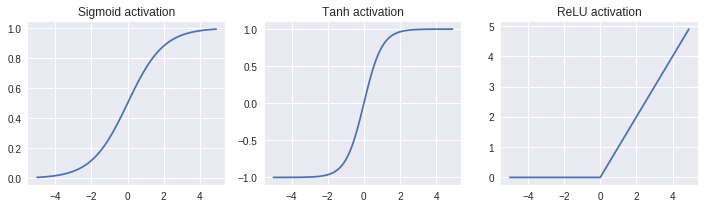

In [0]:
# Fig size
plt.figure(figsize=(12,3))

# Data
x = torch.arange(-5., 5., 0.1)

# Sigmoid activation (constrain a value between 0 and 1.)
plt.subplot(1, 3, 1)
plt.title("Sigmoid activation")
y = torch.sigmoid(x)
plt.plot(x.numpy(), y.numpy())

# Tanh activation (constrain a value between -1 and 1.)
plt.subplot(1, 3, 2)
y = torch.tanh(x)
plt.title("Tanh activation")
plt.plot(x.numpy(), y.numpy())

# Relu (clip the negative values to 0)
plt.subplot(1, 3, 3)
y = F.relu(x)
plt.title("ReLU activation")
plt.plot(x.numpy(), y.numpy())

# Show plots
plt.show()

# Initializing weights

So far we have been initializing weights with small random values and this isn't optimal for convergence during training. The objective is to have weights that are able to produce outputs that follow a similar distribution across all neurons. We can do this by enforcing weights to have unit variance prior the affine and non-linear operations.

A popular method is to apply [xavier initialization](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization), which essentially initializes the weights to allow the signal from the data to each deep into the network. We're going to use this in our models with PyTorch.

You may be wondering why we don't do this for every forward pass and that's a great question. We'll look at more advanced strategies that help with optimization like batch/layer normalization, etc. in future lessons.

In [0]:
# Multilayer Perceptron 
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def init_weights(self):
        init.xavier_normal(self.fc1.weight, gain=nn.init.calculate_gain('relu')) 

    def forward(self, x_in, apply_softmax=False):
        a_1 = F.relu(self.fc1(x_in)) # activaton function added!
        y_pred = self.fc2(a_1)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred

# Overfitting

Though neural networks are great at capturing non-linear relationships they are highly susceptible to overfitting to the training data and failing to generalize on test data. Just take a look at the example below where we generate completely random data and are able to fit a model with [$2*N*C + D$](https://arxiv.org/abs/1611.03530) hidden units. The training performance is great but the overfitting leads to very poor test performance. We'll be covering strategies to tackle overfitting in future lessons.

In [0]:
# Arguments
args = Namespace(
    seed=1234,
    num_samples_per_class=40,
    dimensions=2,
    num_classes=3,
    train_size=0.75,
    test_size=0.25,
    num_hidden_units=2*40*3+2 , # 2*N*C + D
    learning_rate=1e-3,
    regularization=1e-3,
    num_epochs=1000,
)

# Set seed for reproducability
np.random.seed(args.seed)

In [0]:
# Generate random data
X = torch.randn(args.num_samples_per_class*args.num_classes, args.dimensions).float()
y = torch.LongTensor([[i]*args.num_samples_per_class 
                       for i in range(args.num_classes)]).view(-1)
print ("X: {0}".format(np.shape(X)))
print ("y: {0}".format(np.shape(y)))

X: torch.Size([120, 2])
y: torch.Size([120])


In [0]:
# Shuffle data
shuffle_indicies = torch.LongTensor(random.sample(range(0, len(X)), len(X)))
X = X[shuffle_indicies]
y = y[shuffle_indicies]

# Split datasets
test_start_idx = int(len(X) * args.train_size)
X_train = X[:test_start_idx] 
y_train = y[:test_start_idx] 
X_test = X[test_start_idx:] 
y_test = y[test_start_idx:]
print("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))

We have 90 train samples and 30 test samples.


In [0]:
# Multilayer Perceptron 
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        print 
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def init_weights(self):
        init.xavier_normal(self.fc1.weight, gain=nn.init.calculate_gain('relu'))

    def forward(self, x_in, apply_softmax=False):
        a_1 = F.relu(self.fc1(x_in)) 
        y_pred = self.fc2(a_1)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred

In [0]:
# Initialize model
model = MLP(input_dim=args.dimensions, hidden_dim=args.num_hidden_units, 
            output_dim=args.num_classes)
print (model.named_modules)

<bound method Module.named_modules of MLP(
  (fc1): Linear(in_features=2, out_features=242, bias=True)
  (fc2): Linear(in_features=242, out_features=3, bias=True)
)>


In [0]:
# Optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

In [0]:
# Training
for t in range(args.num_epochs):
    # Forward pass
    y_pred = model(X_train)

    # Accuracy
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)

    # Loss
    loss = loss_fn(y_pred, y_train)
    
    # Verbose
    if t%100==0: 
        print ("epoch: {0:02d} | loss: {1:.4f} | accuracy: {2:.1f}%".format(
            t, loss, accuracy))

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

epoch: 00 | loss: 1.1201 | accuracy: 35.6%
epoch: 100 | loss: 0.9448 | accuracy: 51.1%
epoch: 200 | loss: 0.8145 | accuracy: 66.7%
epoch: 300 | loss: 0.7117 | accuracy: 72.2%
epoch: 400 | loss: 0.6309 | accuracy: 76.7%
epoch: 500 | loss: 0.5663 | accuracy: 80.0%
epoch: 600 | loss: 0.5146 | accuracy: 82.2%
epoch: 700 | loss: 0.4734 | accuracy: 82.2%
epoch: 800 | loss: 0.4378 | accuracy: 83.3%
epoch: 900 | loss: 0.4063 | accuracy: 85.6%


In [0]:
# Predictions
_, pred_train = model(X_train, apply_softmax=True).max(dim=1)
_, pred_test = model(X_test, apply_softmax=True).max(dim=1)

In [0]:
# Train and test accuracies
train_acc = get_accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 87.8%, test acc: 43.3%


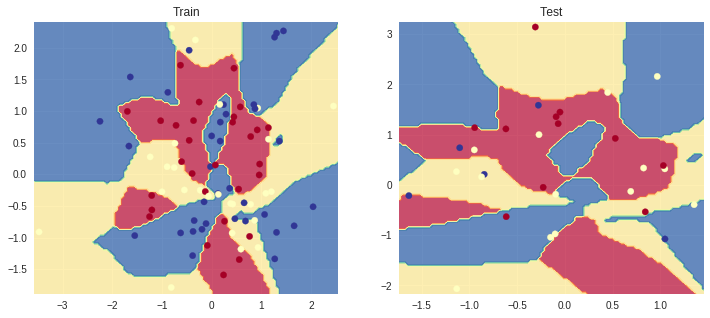

In [0]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

             precision    recall  f1-score   support

          0       0.47      0.73      0.57        11
          1       0.57      0.29      0.38        14
          2       0.17      0.20      0.18         5

avg / total       0.47      0.43      0.42        30



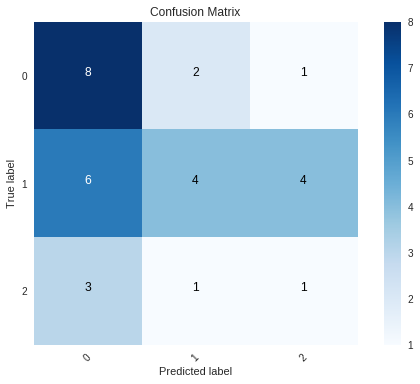

In [0]:
# Confusion matrix
cm = confusion_matrix(y_test, pred_test)
plot_confusion_matrix(cm=cm, classes=[0, 1, 2])
print (classification_report(y_test, pred_test))

# Dropout

A great technique to overcome overfitting is to increase the size of your data but this isn't always an option. Fortuntely, there are methods like regularization and dropout that can help create a more robust model. We've already seen regularization and we can easily add it in our optimizer to use it in PyTorch. 

Dropout is a technique (used only during training) that allows us to zero the outputs of neurons. We do this for p% of the total neurons in each layer and it changes every batch. Dropout prevents units from co-adapting too much to the data and acts as a sampling strategy since we drop a different set of neurons each time.

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/dropout.png" width=400>

In [0]:
# Arguments
args.dropout_p = 0.1 # 40% of the neurons are dropped each pass
args.lambda_l2 = 1e-4 # L2 regularization

In [0]:
# Multilayer Perceptron 
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_p) # Defining the dropout
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def init_weights(self):
        init.xavier_normal(self.fc1.weight, gain=nn.init.calculate_gain('relu'))

    def forward(self, x_in, apply_softmax=False):
        z = F.relu(self.fc1(x_in))
        z = self.dropout(z) # dropping neurons
        y_pred = self.fc2(z)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred

In [0]:
# Initialize model
model = MLP(input_dim=args.dimensions, 
            hidden_dim=args.num_hidden_units, 
            output_dim=args.num_classes, 
            dropout_p=args.dropout_p)
print (model.named_modules)

# Optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, 
                       weight_decay=args.lambda_l2) # Adding L2 regularization

# Training
pass

<bound method Module.named_modules of MLP(
  (fc1): Linear(in_features=2, out_features=242, bias=True)
  (dropout): Dropout(p=0.1)
  (fc2): Linear(in_features=242, out_features=3, bias=True)
)>


# Additional resources

- interpretability (easy w/ at with binary tasks)
- dropconnect (but not really used)
- PReLU activation function